#**Drive mount**

In [ ]:
from google.colab import drive
import shutil
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import scipy.io
import pandas as pd
import os
import random
import cv2
from google.colab.patches import cv2_imshow
import skimage
import matplotlib.pyplot as plt
import itertools
import torch
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from scipy import signal
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
import xgboost as xgb

##**Normalizzazione**

In [ ]:
def _normalize_trial(trial):
  trial_avg = np.mean(trial)
  trial_std = np.std(trial)

  trial = (trial - trial_avg)/trial_std
  return trial

# **Splitting, Flatten and ML_Classification**

In [ ]:
from sklearn.model_selection import train_test_split

def split_subjs(trials, labels):
    if labels[0] == 0 and labels[112] == 1:
      #print('Sub Dispari')
      NONSOCIAL_RANGE = range(0,112)
      SOCIAL_RANGE = range(112,224)
      TRAIN_RANGE_S = range(0,79)
      TRAIN_RANGE_NONS = range(112,191)
      TEST_RANGE_S = range(79,101)
      TEST_RANGE_NONS = range(191,213)
      VAL_RANGE_S = range(101,112)
      VAL_RANGE_NONS = range(213,224)


      nonsoc_trials = []
      for nonsoc in NONSOCIAL_RANGE:
        nonsoc_trials.append(trials[nonsoc])
      seed = 42
      random.seed(seed)
      random.shuffle(nonsoc_trials)

      soc_trials = []
      for soc in SOCIAL_RANGE:
        soc_trials.append(trials[soc])
      seed = 42
      random.seed(seed)
      random.shuffle(soc_trials)

      trials = nonsoc_trials + soc_trials

      train_data = []
      train_labels = []
      for tns in TRAIN_RANGE_NONS:
        train_data.append(trials[tns])
        train_labels.append(labels[tns])
      for ts in TRAIN_RANGE_S:
        train_data.append(trials[ts])
        train_labels.append(labels[ts])

      test_data = []
      test_labels = []
      for tens in TEST_RANGE_NONS:
        test_data.append(trials[tens])
        test_labels.append(labels[tens])
      for tes in TEST_RANGE_S:
        test_data.append(trials[tes])
        test_labels.append(labels[tes])

      val_data = []
      val_labels = []
      for vns in VAL_RANGE_NONS:
        val_data.append(trials[vns])
        val_labels.append(labels[vns])
      for vs in VAL_RANGE_S:
        val_data.append(trials[vs])
        val_labels.append(labels[vs])

    # ----- PARI ---------

    if labels[0] == 1 and labels[112] == 0:
      #print('Sub Pari')
      SOCIAL_RANGE = range(0,112)
      NONSOCIAL_RANGE = range(112,224)

      TRAIN_RANGE_S = range(0,79)
      TRAIN_RANGE_NONS = range(112,191)

      TEST_RANGE_S = range(79,101)
      TEST_RANGE_NONS = range(191,213)

      VAL_RANGE_S = range(101,112)
      VAL_RANGE_NONS = range(213,224)


      soc_trials = []
      for soc in SOCIAL_RANGE:
        soc_trials.append(trials[soc])
      seed = 42
      random.seed(seed)
      random.shuffle(soc_trials)

      nonsoc_trials = []
      for nonsoc in NONSOCIAL_RANGE:
        nonsoc_trials.append(trials[nonsoc])
      seed = 42
      random.seed(seed)
      random.shuffle(nonsoc_trials)

      trials = soc_trials + nonsoc_trials

      train_data = []
      train_labels = []

      for ts in TRAIN_RANGE_S:
        train_data.append(trials[ts])
        train_labels.append(labels[ts])
      for tns in TRAIN_RANGE_NONS:
        train_data.append(trials[tns])
        train_labels.append(labels[tns])

      test_data = []
      test_labels = []


      for tes in TEST_RANGE_S:
        test_data.append(trials[tes])
        test_labels.append(labels[tes])
      for tens in TEST_RANGE_NONS:
        test_data.append(trials[tens])
        test_labels.append(labels[tens])

      val_data = []
      val_labels = []


      for vs in VAL_RANGE_S:
        val_data.append(trials[vs])
        val_labels.append(labels[vs])
      for vns in VAL_RANGE_NONS:
        val_data.append(trials[vns])
        val_labels.append(labels[vns])

    #print(f'Train Data Shape: ', np.shape(train_data))
    #print(f'Test Data Shape: ', np.shape(test_data))
    #print(f'Val Data Shape: ', np.shape(val_data))

    return train_data,train_labels, test_data, test_labels, val_data, val_labels

**Flatten per ML_Classifiers**




In [ ]:
def flatten(train_data, test_data, val_data):

    train_data = np.array(train_data)
    test_data = np.array(test_data)
    val_data = np.array(val_data)

    train_loop = range(0,158)
    test_loop = range(0,44)
    val_loop = range(0,22)

    #print(f'TRAIN PRIMA: ', np.shape(train_data))
    #print(f'TEST PRIMA: ', np.shape(test_data))
    #print(f'VAL PRIMA: ', np.shape(val_data))

    train_data_flatt = []
    test_data_flat = []
    test_data_flatt = []
    val_data_flatt = []
    

    for t in train_loop:
      train_data_flatt.append(train_data[t].flatten())

    for te in test_loop:
      test_data_flat.append(test_data[te].flatten())

    for v in val_loop:
      val_data_flatt.append(val_data[v].flatten())

    test_data_flatt = test_data_flat + val_data_flatt


    #print(f'TRAIN DOPO: ', np.shape(train_data_flatt))
    #print(f'TEST DOPO: ', np.shape(test_data_flatt))
    #print(f'VAL DOPO: ', np.shape(val_data_flatt))

    return train_data_flatt, test_data_flatt, val_data_flatt



In [ ]:
def ml_classification(train_data_flatt, train_labels, test_data_flatt):
    # --SVM--
    #Create a svm Classifier
    svm_clf = svm.SVC(kernel='linear') # Linear Kernel

    #Train the model using the training sets
    svm_clf.fit(train_data_flatt, train_labels)

    #Predict the response for test dataset
    y_pred_svm = svm_clf.predict(test_data_flatt)

    #SVM RBF
    svm_clf = svm.SVC(kernel='rbf') # RBF Kernel

    #Train the model using the training sets
    svm_clf.fit(train_data_flatt, train_labels)

    #Predict the response for test dataset
    y_pred_svm_rbf = svm_clf.predict(test_data_flatt)

    # --RandomForest--

    rf_clf = RandomForestClassifier()

    rf_clf.fit(train_data_flatt, train_labels)

    y_pred_rf = rf_clf.predict(test_data_flatt)


    print('SVM of ' + s + ': ', metrics.accuracy_score(test_labels, y_pred_svm))
    print('SVM rbf of ' + s + ': ', metrics.accuracy_score(test_labels, y_pred_svm_rbf))
    print('RandomForest of ' + s + ': ', metrics.accuracy_score(test_labels, y_pred_rf))
    print('---------------------------------------------------------------')

    return metrics.accuracy_score(test_labels, y_pred_svm), metrics.accuracy_score(test_labels, y_pred_svm_rbf), metrics.accuracy_score(test_labels, y_pred_rf)

#**All Subjs**

In [ ]:
SUBJECTS_FOLDER = '/content/drive/MyDrive/Social memory cuing full dataset/derivatives/EEGPreprocessedDataTableStudy'
SINGLE_SUBJECT = os.path.join(SUBJECTS_FOLDER, "sub-10/ProcessedData/data_ica.mat")
SUBJECTS = [ name for name in os.listdir(SUBJECTS_FOLDER) if os.path.isdir(os.path.join(SUBJECTS_FOLDER, name)) ]
SUBJECTS.sort()
DATA = "ProcessedData/data_ica.mat"

In [ ]:
NUM_CHANNELS = 29
NUM_TRIAL = 224
TRIAL_RANGE = range(0, 224)
cueing_fase = range(1250,1750)

svm_acc_sum, svm_rbf_acc_sum, rf_acc_sum = 0, 0, 0
svm_accs, svm_rbf_accs, rf_accs = [], [], []

for s in SUBJECTS:
  if s == 'sub-02' or s == 'sub-07' or s == 'sub-36':
    continue
  else:
    curr_subj = (SUBJECTS_FOLDER + '/' + s + "/ProcessedData/data_ica.mat")
    mat = scipy.io.loadmat(curr_subj)
    trial = mat['trial']
    trialinfo = mat['trialinfo']
    trial = np.transpose(np.squeeze(trial))
    trials = []
    labels = []
    trials_norm = []
    for i, t in enumerate(trial):
      trials.append(t[ :NUM_CHANNELS, cueing_fase])
      labels.append(trialinfo[i, 5]-1)

    trials = list(signal.decimate(np.transpose(trials, [0, 2, 1]), 4, axis = 1))

    #for tr in TRIAL_RANGE:
      #trials_norm.append(_normalize_trial(trials[tr]))

    train_data, train_labels, test_data, test_labels, val_data, val_labels = split_subjs(trials, labels)
    test_labels = test_labels + val_labels

    train_data_flatt, test_data_flatt, val_data_flatt = flatten(train_data, test_data, val_data)
    svm_acc, svm_rbf_acc, rf_acc = ml_classification(train_data_flatt, train_labels, test_data_flatt)
    svm_acc_sum += svm_acc
    svm_rbf_acc_sum += svm_rbf_acc
    rf_acc_sum += rf_acc

    svm_accs.append(svm_acc)
    svm_rbf_accs.append(svm_rbf_acc)
    rf_accs.append(rf_acc)

print("Avg svm accuracy: " + str(svm_acc_sum/44))
print("RF accuracy: " + str(rf_acc_sum/44))
print("Avg rbf svm accuracy: " + str(svm_rbf_acc_sum/44))

SVM of sub-01:  0.5454545454545454
SVM rbf of sub-01:  0.5757575757575758
RandomForest of sub-01:  0.6060606060606061
---------------------------------------------------------------
SVM of sub-03:  0.5454545454545454
SVM rbf of sub-03:  0.5606060606060606
RandomForest of sub-03:  0.5606060606060606
---------------------------------------------------------------
SVM of sub-04:  0.6666666666666666
SVM rbf of sub-04:  0.7424242424242424
RandomForest of sub-04:  0.7272727272727273
---------------------------------------------------------------
SVM of sub-05:  0.6060606060606061
SVM rbf of sub-05:  0.696969696969697
RandomForest of sub-05:  0.7878787878787878
---------------------------------------------------------------
SVM of sub-06:  0.45454545454545453
SVM rbf of sub-06:  0.7878787878787878
RandomForest of sub-06:  0.803030303030303
---------------------------------------------------------------
SVM of sub-09:  0.6212121212121212
SVM rbf of sub-09:  0.6515151515151515
RandomForest of s

In [ ]:
import matplotlib.pyplot as plt
import math 
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax.bar(['Graph-SAGE', 'GCN', 'GIN', 'SVM linear', 'Random Forest'], [0.843, 0.836, 0.821, 0.814, 0.786])
ax.set_ylim([0.75, 0.85])
ax.set_ylabel("Accuracy")
plt.show()

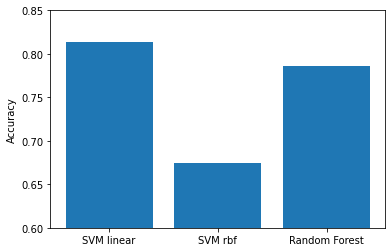

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#fig.set_size_inches(10, 7)
ax.set_ylim([0.60, 0.85])
#ax.bar(['Graph-SAGE', 'GCN', 'GCN*'], [0.846, 0.836, 0.781]) #pearson
ax.bar(['SVM linear', 'SVM rbf', 'Random Forest'], [0.814, 0.674, 0.786]) #raw
#ax.bar(['SVM linear', 'SVM rbf', 'Random Forest'], [0.70, 0.63, 0.647]) #plv = [0.70, 0.63, 0.647]
#ax.set_title("ML methods accuracies given PLV based features")
ax.set_ylabel("Accuracy")
plt.show()

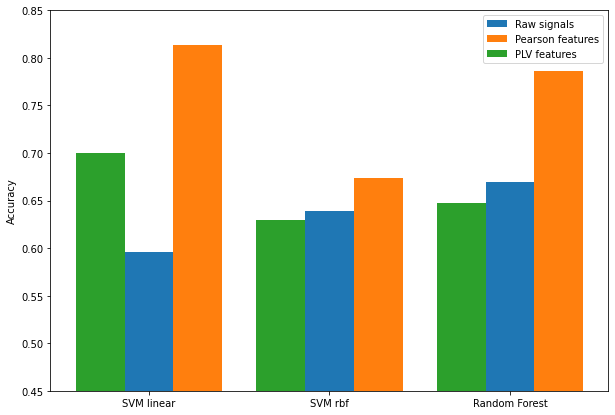

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['SVM linear', 'SVM rbf', 'Random Forest']
raw = [0.596, 0.639, 0.67]
pearson = [0.814, 0.674, 0.786]
plv = [0.70, 0.63, 0.647]

x = np.arange(len(labels))  # the label locations
width = 0.27  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
rects1 = ax.bar(x, raw, width, label='Raw signals')
rects2 = ax.bar(x + width, pearson, width, label='Pearson features')
rects3 = ax.bar(x - width, plv, width, label='PLV features')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
#ax.set_title('ML methods accuracies comparison PLV-Pearson features')
ax.set_xticks(x)
ax.set_ylim(0.45, 0.85)
ax.set_xticklabels(labels)
ax.legend()

#fig.tight_layout()

plt.show()